# Goal

See if trading cryptos which are shift-correlated BTCUSDT is profitable

So far:
- a few stocks are certainly shift-correlated

- taker's fee wipes out profits for most simple strategies (even with a threshold) for OSMO

To test
- simple taker strategies (take when expected profit > 2*fees)
- take and hold (take, but only change position when expected pnl change > fees)
- market making strategies

pnl attribution:
- how much from fees?
- how much from desired position?
- how much from holding undesired position?
- how much would spread affect pnl?

# Steps

Components of a backtest
- choose a signal (BTC returns, combination of returns, etc)
- use signal --> predicted returns for a specific stock
- take position based on predicted returns, fees, spread, etc. (only take position if predicted returns > cost of getting position)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [3]:
df = pd.read_csv('./5min_data.csv')
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
df.head()
print("Daterange:", df.index[0], df.index[-1])

Daterange: 2024-09-01 00:00:00 2024-11-21 19:00:00


In [4]:
# From FindStocks, prepare df
start_train  = datetime(2024, 9, 1)
end_train = datetime(2024, 10, 31)
end_test = datetime(2024, 11, 21, 19)
train_df = df.loc[start_train:end_train].copy()
test_df = df.loc[end_train + timedelta(hours=1):end_test].copy()

def getReturnDf(data):
    data = data.dropna(how='any', axis=1).copy()

    # Get most stock returns
    stocks = [colName.split('_')[0] for colName in data.columns]

    stock_returns = {
        f'{stock}_return': (data[f'{stock}_close'] - data[f'{stock}_close'].shift(1))/data[f'{stock}_close'].shift(1)*100*100
        for stock in stocks
    }

    # Get indicator returns, shifted extra
    indicators = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT']
    indicator_returns = {
        f'{indicator}_prev_return': ((data[f'{indicator}_close'] - data[f'{indicator}_close'].shift(1))/data[f'{indicator}_close'].shift(1)).shift(1)*100*100
        for indicator in indicators
    }

    return_df = pd.DataFrame({**stock_returns, **indicator_returns})
    return_df = return_df.drop(labels=return_df.index[:2], axis=0)
    return return_df

train_returns = getReturnDf(train_df)
test_returns = getReturnDf(test_df)

/Users/akhilkammila/miniconda3/envs/tradingClub/lib/python3.12/site-packages/seaborn/categorical.py:253: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


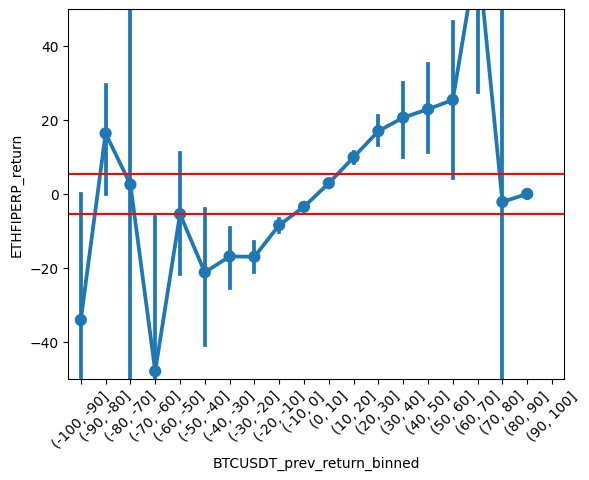

/var/folders/_c/j62lsd3n7x9_vq272kdsl3fc0000gn/T/ipykernel_12120/2770458758.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df.groupby(f'BTCUSDT_prev_return_binned')[f'{stock}_return'].agg(


,mean,std,count
BTCUSDT_prev_return_binned,,,
"(-100, -90]",-34.114164,31.810939,3
"(-90, -80]",16.376693,15.001985,3
"(-80, -70]",2.532864,87.975320,9
"(-70, -60]",-47.975993,97.185478,19
"(-60, -50]",-5.450132,57.686060,41
"(-50, -40]",-21.223784,76.459901,64
"(-40, -30]",-16.921405,51.026135,159
"(-30, -20]",-17.006932,45.682545,510
"(-20, -10]",-8.419242,39.549177,1765


In [5]:
# Visualizations to find a proper utility function
import statsmodels.api as sm

def findUtility(df, stock):
    X = df['BTCUSDT_prev_return']
    model = sm.OLS(df[f'{stock}_return'], X).fit()
    # print(model.summary())

    predictions = model.predict(X)
    df['residuals'] = df[f'{stock}_return'] - predictions
    bins = np.arange(-100, 101, 10)
    df['BTCUSDT_prev_return_binned'] = pd.cut(df['BTCUSDT_prev_return'], bins=bins)
    # display(df['BTCUSDT_prev_return_binned'].value_counts(normalize=True))
    # sns.boxplot(data=df, x='BTCUSDT_prev_return_binned', y='residuals')
    # sns.regplot(data=df, x='BTCUSDT_prev_return', y=f'{stock}_return', scatter_kws = {'alpha': 0.01}, order=3)

    sns.pointplot(data=df, x='BTCUSDT_prev_return_binned', y=f'{stock}_return')
    plt.ylim(bottom=-50, top=50)
    plt.axhline(y=5.5, color='red')
    plt.axhline(y=-5.5, color='red')
    plt.xticks(rotation=45)
    plt.show()

    bin_stats = df.groupby(f'BTCUSDT_prev_return_binned')[f'{stock}_return'].agg(
        [('mean', 'mean'),
         ('std', lambda x : np.std(x, ddof=1)),
         ('count', 'count')])
    display(bin_stats)
    # lambda x: (abs(np.mean(x))-5.5)/np.sqrt(np.var(x)/(len(x)-1))]).reset_index()

findUtility(train_returns, 'ETHFIPERP')

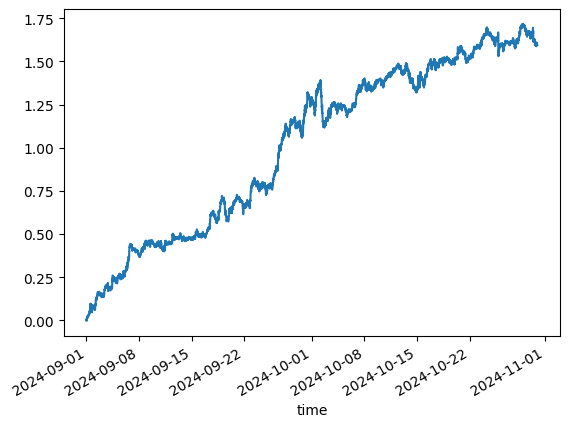

In [27]:
# Backtest
class Backtest:
    def __init__(self, data, x, y):
        self.df = data
        self.x = x # usually BTC prevReturn
        self.y = y # usually new stock returns
        self.fee = 0.0015

    """
    predictionFunction should take in
        1) prevBTCUSDT return
        2) current x stock position
    and output
        1) new current stock position

    basic logic
        1) prev BTCUSDT return --> tells us to go long or short
        2) if already long or signal not strong enough --> don't change position
        3) effectively, we will always be at position 1, or at position -1
    """
    def calculatePositions(self, predictionFunction):
        self.df['position'] = 0

        for i in range(1, len(self.df.index)):
            btc_return = self.df.at[self.df.index[i], self.x] # bitcoin return
            prev_position = self.df.at[self.df.index[i-1], 'position'] # PREV position

            self.df.loc[self.df.index[i], 'position'] = predictionFunction(btc_return, prev_position)
    
    def graph_pnl(self):
        self.df['pnl'] = self.df['position'] * self.df[self.y].shift(-1)/100/100 # convert back from bps --> decimal
        self.df['fees'] = abs(self.df['position'] - self.df['position'].shift(1))*self.fee
        self.df['cumpnl'] = (self.df['pnl'] - self.df['fees']).cumsum()

        self.df['cumpnl'].plot()

def significantThreshold(btc_prev_return, x_position):
    significant = abs(btc_prev_return) > 20
    
    if not significant: return x_position # don't change position if insignificant
    if significant: return np.sign(btc_prev_return)

def naive(btc_prev_return, x_position):
    return np.sign(btc_prev_return)

def linear(btc_prev_return, x_position):
    pos = btc_prev_return/100
    if abs(pos) > 1: return np.sign(pos)
    return pos

def long(btc_prev_return, x_position):
    return 1

b = Backtest(train_returns, x='BTCUSDT_return', y='ETHFIPERP_return')
b.calculatePositions(predictionFunction = significantThreshold)
b.graph_pnl()

In [7]:
df[['BTCUSDT_prev_return', 'OSMOUSDT_return', 'predicted_returns', 'position', 'pnl', 'cumpnl']].head(30)

KeyError: "None of [Index(['BTCUSDT_prev_return', 'OSMOUSDT_return', 'predicted_returns',\n       'position', 'pnl', 'cumpnl'],\n      dtype='object')] are in the [columns]"